# Book reviews classification using Arabic ULMFIT model
### You can get this dataset from https://github.com/elnagara/BRAD-Arabic-Dataset .
This dataset contains 510,600 book reviews in Arabic language. The reviews were collected from GoodReads.com website during June/July 2016. The reviews are expressed mainly in Modern Standard Arabic but there are reviews in dialectal Arabic as well.
##### *Citation*:
> Elnagar A. and Einea O. 'BRAD 1.0: Book reviews in Arabic dataset'. 2016 IEEE/ACS 13th International Conference of Computer Systems and Applications (AICCSA), pp. 1-8, Nov 2016. DOI: 10.1109/AICCSA.2016.7945800.

For more information about ULMFIT see [Paper](https://arxiv.org/abs/1801.06146) & [Blog post](http://nlp.fast.ai/).

### Using our pretrained Arabic ULMFIT language model we do the following:
1- Preprocess our dataset and get it ready for use in the coming steps by creating a language model databunch & classifer databunch.

2- Load our language model with pretrained weights then fine-tune it to our dataset.

3- Create a classifier on top of the encoder of the language model.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from fastai.text import *
import path
import copy

In [3]:
#Latest dev version of fastai in order to get some fixes for QRNNs
import fastai; fastai.__version__

'1.0.51.dev0'

In [5]:
data_path = Path('data')
lm_path = Path('.')

### 1- Pre-processing our Dataset :

**This notebook uses the unbalanced reviews file (9% neg, 79% pos, 12% ntl),  you can find the notebook that uses the balanced reviews in the same github repo.**

In [9]:
unbalanced_df = pd.read_csv(data_path/'unbalanced_reviews.tsv',delimiter='\t',encoding='utf-8'
                            ,names=['rating','review id','user id','book id','review'])

In [10]:
unbalanced_df.head()

,rating,review id,user id,book id,review
0,4,1682581870,57098525,13637412,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,5,1682385404,56693085,13637412,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...
2,4,1682039752,30836455,13637412,رواية تلامس الروح بعمقها، فخورة اني اخيرا لقيت...
3,5,1681553886,6680940,13637412,رواية محكمة بكل اختصار. وكان الجزء المفضل بالن...
4,3,1681248984,19011044,13637412,هذا الكتاب يحزن مرا، ظلم واضطهاد عيسى بلا ذنب ...


In [11]:
unbalanced_df.shape

(510599, 5)

*Create A held-out test dataset using 10% of our full dataset. and drop it from the full dataset.*

In [12]:
test_df = unbalanced_df.sample(frac = .1 ,replace=False,random_state = 42)

In [13]:
unbalanced_df = unbalanced_df.drop(test_df.index)
unbalanced_df.shape

(459539, 5)

In [14]:
unbalanced_df.to_csv(data_path/'unbalanced_reviews_train.csv',index=False)
test_df.to_csv(data_path/'unbalanced_reviews_test.csv',index=False)

*Create 2 csv files containing our train/valid and our test datasets.*

In [7]:
unbalanced_train_df = pd.read_csv(data_path/'unbalanced_reviews_train.csv')
unbalanced_test_df = pd.read_csv(data_path/'unbalanced_reviews_test.csv')

* Create a Language model databunch that does all the necessary preprocessing like tokenization and numericalization.

* All the text in the dataset is concatenated and the labels are ignored. Instead, the target is the next word in the sentence.

* We also create a validation set that is 10% of our full dataset (80% train 10% valid 10% test).

In [17]:
reviews_lm_data = (TextList.from_df(unbalanced_train_df,cols=['review'])
                   .split_by_rand_pct(.1)
                   .label_for_lm()
                   .databunch(bs=64))

In [18]:
reviews_lm_data.show_batch()

idx,text
0,الاحداث وتنسى نفسك فيها ، عمل رائع . xxbos رواية محكمة بكل اختصار . وكان الجزء المفضل بالنسبة لي هو وصف الكاتب للحياة عيسى في الفلبين . على الرغم من أن الرواية تصف واقع الكويت ( بكل واقعية وبدون مبالغة ) الا ان القاريء الخليجي بصفة عامه يستطيع أن يجد نفسه ومجتمعه بين سطورها . خلق الكاتب xxunk متناقضتين ( يوسف xxunk xxunk والوجه الغير كويتي ) و ( غسان
1,لما قرأتها قولت اية دا ! ! ! . احمد مراد الي كاتبها ! ! . الرواية فيها غموض جامد و توهان . تاني حاجة .. ان موضوع الرواية . لما ظهر حقيقة الموضوع ف النهاية يعني . دا بجد قفلني جدا xxbos العلامة الكاملة بضمير مرتاح . احمد مراد ببساطة هو الروائي الابرز بين كُتاب الجيل الحالي قلم غير xxunk في اختيار مواضيع الروايات ... سهولة في السرد ولغة
2,بها xxunk في بادئ الأمر ، ولا نغفر لها سقوطها الغريب لاحقا وضعف شخصيتها لمجرد سماع صوت xxunk خلف xxunk هاتف ، وهي البطلة صاحبة المبادئ والقيم والعائلة المحافظة . ما xxunk حقا في الرواية حبكتها والأحداث التي جمعت البطلين والتي تجعلنا وكأننا xxunk واحدا من أفلام الثمانينيات العربية . منذ منتصف الرواية فقدت شغف البداية ، وتوقعت النهاية ، وفقدت ما هو أعظم من ذلك : عنصرا المفاجأة ورسالة
3,! ! . في النهاية ، راوية عزازيل استحقت بجدارة الجائزة العالمية للرواية العربية .. xxunk xxunk لقراءتها ؛ ربطة xxunk الأدب في الرواية xxunk جداً. شكراً جزيلاً ليوسف زيدان على هذا العمل xxunk الذي xxunk نظرتي للرواية العربية . xxbos فى حاجة مش فاهماها فى الكتاب دا : xxup d. هو قصته حقيقية ؟ يعنى كان فيه ألواح مدفونة فى صندوق و الرواية دى ترجمة حرفية ليها ؟ و
4,شهامة الفتى من شبرا الذي يحمي اخته ويظهر شيم حماية الغريب والتضحية بالذات xxunk ( برغم كون الغرباء من سكان يوتوبيا الاعداء وفي المقابل كان رد الجميل من هؤلاء هو قتله ) ، وفي النهاية كانت ثورة الجياع لا مفر منها xxbos أجلت الــ review لهذه الرواية .. ربما لأنني كنت على يقين أنني سأعود إليها و أعيد قراءتها يوما ما .. و قد حدث : xxup d. طبعا ..


*Save our databunch so we can load it instantly later if we want.*

In [19]:
reviews_lm_data.save('unbalanced_reviews_lm')

In [20]:
reviews_lm_data = load_data(lm_path,'unbalanced_reviews_lm')

* Create a classification databunch that does all the necessary preprocessing like tokenization and numericalization.
* We map the rating to labels ('pos', 'neg' or 'ntl').
* We also pass the vocabulary (mapping from ids to words) that we want to use to ensure that our classification databunch will use the same dictionary as our language model databunch.

In [21]:
label_for_reviews = lambda x: 'neg' if(x[1] < 3) else ('pos' if x[1] > 3 else 'ntl')

In [22]:
reviews_cls_data = (TextList.from_df(unbalanced_train_df,cols=['review','rating'],vocab=reviews_lm_data.train_ds.vocab)
                   .split_by_rand_pct(.1)
                   .label_from_func(label_for_reviews)
                   .databunch(bs=64))

In [23]:
reviews_cls_data.show_batch()

text,target
xxbos xxrep 6 ? xxrep 5 ? xxrep 4 ? ? ? xxrep 5 ? xxrep 5 ? xxrep 6 ? ? ? ? xxrep 6 ? . xxrep 6 ? ? ? ? xxrep 5 ? xxrep 5 ? xxrep 7 ? ? ? xxrep 6 ? xxrep 6 ? ، xxrep 8 ? xxrep 9 ? xxrep 7 ? xxrep 4 ? xxrep 6 ? ، xxrep 4,pos
"xxbos من موسى . .. .. لمحمد . كان من الضروري xxunk سى أن يجد بني إسرائيل عبيدا في مصر , و أن xxunk المصريون و ذلك حتى يكونوا مستعدين للسير خلفه للتخلص من العبودية , . و كان من الضروري أيضا أن يجد xxunk أن الفرس xxunk على إمبراطورية xxunk , و أن يكون xxunk ضعفاء و xxunk بسبب طول فترة السلم , . و ما كان xxunk أن",pos
xxbos والعنوان الفرعي : . ( يوميات طالب في بلد المتناقضات ) . ، وهذه المتناقضات هي لواء الإسلام الذي يرفرف xxunk إلى جنب مع لواء العلمانية في رقعة واحدة من الأرض تسمى تركيا ! ، ولكن كاتب هذه اليوميات ( التي xxunk سريعًا ) على يقين من إن الفتح الإسلامي الثاني xxunk قادم بإذن الله قريب ، إن لم يكن في المستقبل القريب فليكن في آخر الزمان كما وعد,ntl
"xxbos بدأت xxunk و أنا أنظر بخوف و وجل إلى ذلك الكتاب الذى xxunk xxunk و انا استسلمت فى غير xxunk إلى xxunk كمن فقد عقله ثم xxunk توحدت روحى مع ذلك الكتاب , توقعت الأسوأ من شكسبير و أن أتوه فى مقدرته اللغوية الفائقة .. بدايةً و قبل xxunk فى ذلك البستان البديع الذى صنع شكسبير من خلال شخصياته , أود أن xxunk على لغة ذلك xxunk , الرائع",pos
"xxbos يسعى كتاب ( مَنْ xxunk الذِي xxunk xxunk ؟ : أخطاء xxunk xxunk xxunk ) للكاتبة "" حياة الياقوت "" إلى لفت انتباهنا لبعض الأخطاء اللغوية التي xxunk عن نسيان أو جهل وأحياناً بسبب عدم xxunk ، وهي الأخطاء التي xxunk في حديثنا اليومي xxunk الطريق وأسماء المنتجات وحتى xxunk .. كما يشرح الكتاب بطريقة مبسطة xxunk علامات الترقيم .. و منه بعض هذه النصوص : . أخطاء إملائية",pos


In [24]:
reviews_cls_data.save('unbalanced_reviews_cls')

In [25]:
reviews_cls_data = load_data(lm_path,'unbalanced_reviews_cls')

## 2- Fine-tune our LM to our Dataset:

In [26]:
pretrained_lm_fname = 'new_lm'
pretrained_itos_fname = 'itos'

* We will create a uni-directional [QRNN] (https://arxiv.org/abs/1611.01576) that will load our pre-trained language model weights stored in `new_lm.pth` and also load  `itos.pkl`  which contains our id to token mapping.
* We also pass it our language model databunch which we will fine-tune our language model to.

In [28]:
emb_sz:int = 400
nh: int = 1550
nl: int = 3

qrnn_config = copy.deepcopy(awd_lstm_lm_config)
dps = dict(output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
qrnn_config.update({'emb_sz':emb_sz, 'n_hid':nh, 'n_layers':nl, 'pad_token':1, 'qrnn':True})
qrnn_config

{'emb_sz': 400,
 'n_hid': 1550,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': True,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2,
 'tie_weights': True,
 'out_bias': True}

In [29]:
lm_learner = language_model_learner(reviews_lm_data,AWD_LSTM,pretrained=False,config=qrnn_config, model_dir=lm_path,drop_mult=.3,pretrained_fnames=(pretrained_lm_fname,pretrained_itos_fname))

In [30]:
lm_learner.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


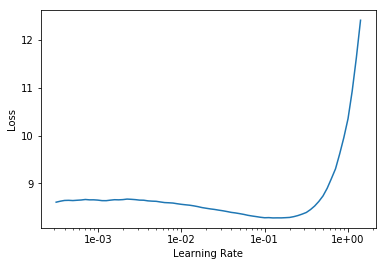

In [31]:
lm_learner.recorder.plot(skip_end=10)

In [32]:
lm_learner.metrics = [accuracy,Perplexity()]

*We train our model starting from the last layer then unfreezing the model and training the entire network*

In [33]:
lm_learner.fit_one_cycle(1,2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.725603,6.400053,0.141682,601.877197,23:11


In [34]:
lm_learner.save('unbalanced-stage1-lm-1epoch')

In [35]:
lm_learner.unfreeze()

In [36]:
lm_learner.fit_one_cycle(2,2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.872296,5.781565,0.171895,324.266510,25:33
1,5.511936,5.412830,0.192067,224.265335,25:33


In [39]:
lm_learner.save('unbalanced-stage2-lm-2epoch')

In [40]:
lm_learner.fit_one_cycle(2,2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.838557,5.712361,0.175539,302.585449,25:35
1,5.471070,5.373119,0.194192,215.534149,25:33


In [41]:
lm_learner.save('unbalanced-stage2-lm-4epoch')

* To evaluate our language model, we run the `Learner.predict` method specifying the number of words we want it to guess.
* We can see that the predicted words don't make much sense but are coherent and follow basic grammer thanks to our language model.

In [44]:
lm_learner.predict('الكتاب جميل',n_words=10)

'الكتاب جميل جداً في طرحه :) . بالورود رغم الإيجاز الممتع ..'

*We save the language model encoder to use it for classification in the next step.*

In [45]:
lm_learner.save_encoder('unbalanced-stage2-lm-enc')

### 3- Creating the classifer:

*We now use the classifer databunch we created earlier to build a classifier with our fine-tuned encoder.* 

In [46]:
qrnn_cls_config = copy.deepcopy(awd_lstm_clas_config)
dps = dict(output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
qrnn_cls_config.update({'emb_sz':emb_sz, 'n_hid':nh, 'n_layers':nl, 'pad_token':1, 'qrnn':True})
qrnn_cls_config

{'emb_sz': 400,
 'n_hid': 1550,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': True,
 'bidir': False,
 'output_p': 0.4,
 'hidden_p': 0.3,
 'input_p': 0.4,
 'embed_p': 0.05,
 'weight_p': 0.5}

In [47]:
clas_learner = text_classifier_learner(reviews_cls_data,AWD_LSTM,config=qrnn_cls_config,model_dir=lm_path,drop_mult=.3)

In [48]:
clas_learner.load_encoder('unbalanced-stage2-lm-enc')

In [49]:
clas_learner.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


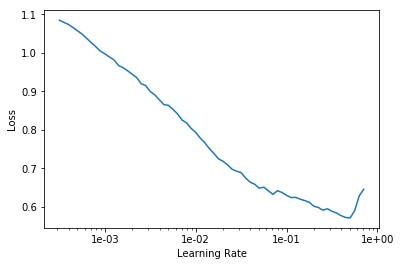

In [50]:
clas_learner.recorder.plot(skip_end=10)

* Again We train our model starting from the last layer and there is no need to unfreeze here -also it raises an `out of memory` exception on a Nvidia p100 (16GB) machine when unfreezed :( .
* we use `F-score` as a metric to compare our results to the cited paper.

In [51]:
clas_learner.metrics = [accuracy,FBeta(beta=3,average='weighted')]

In [52]:
clas_learner.fit_one_cycle(1,2e-3)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.189314,0.035362,0.995365,0.995362,07:23


In [53]:
clas_learner.save('unbalanced-stage1-1epoch')

*We can test our classifier by giving it a review and see the predicted sentiment and its propablity.*

In [1]:
test_text = ['الكتاب جيد','الكتاب جيد ولكن']
test_text

'الكتاب جيد'

In [64]:
[clas_learner.predict(text) for text in test_text]

[(Category pos, tensor(2), tensor([0.3792, 0.0738, 0.5470])),
 (Category neg, tensor(0), tensor([0.8022, 0.1618, 0.0361]))]

*We create a temp databunch containg our held-out test dataset to validate our classifer.*

In [66]:
unbalanced_all_df = pd.concat([unbalanced_train_df,unbalanced_test_df])
unbalanced_all_df.shape

(510599, 5)

In [67]:
reviews_cls_test_data = (TextList.from_df(unbalanced_all_df,cols=['review','rating'],vocab=reviews_lm_data.train_ds.vocab)
                   .split_by_idx(unbalanced_test_df.index)
                   .label_from_func(label_for_reviews)
                   .databunch(bs=64))

In [68]:
#Validate returns (error rate , accuracy,F-score)
clas_learner.validate(reviews_cls_test_data.valid_dl)

[0.029744586, tensor(0.9961), tensor(0.9961)]